In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from sklearn.utils import resample
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# download the data from google drive (will only work on Google Colab)
!gdown --id 1-A6iDGys4tkLxykSbXz41bbVRFBTATr1 #training data
!gdown --id 1-M6Q93Dewd8EOf5Zwv_SbvWz4Vur1n-P #test data


Downloading...
From: https://drive.google.com/uc?id=1-A6iDGys4tkLxykSbXz41bbVRFBTATr1
To: /content/train.csv
100% 3.10M/3.10M [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-M6Q93Dewd8EOf5Zwv_SbvWz4Vur1n-P
To: /content/test.csv
100% 1.64M/1.64M [00:00<00:00, 110MB/s]


In [ ]:
train = pd.read_csv("train.csv")

# Data Exploration

In [ ]:
train.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
# count not racist/sexist
sum(train["label"] == 0)

29720

In [ ]:
# count racist/sexist
sum(train["label"] == 1)

2242

([<matplotlib.axis.XTick at 0x7f4dc11f7a90>,
 <a list of 2 Text major ticklabel objects>)

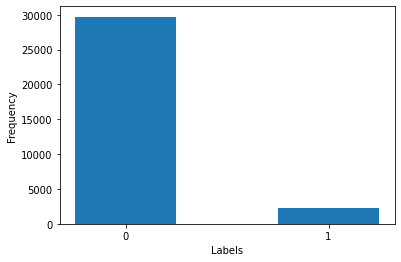

In [ ]:
# plot the data ratio
plt.bar([0,1], train['label'].value_counts(), width=0.5, bottom=None, align='center', data=train)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks([0, 1])

In [ ]:
train['label'].values

array([0, 0, 0, ..., 0, 1, 0])

# Preprocessing step

Our preprocessing function includes:
- lemmatization
- filtering by frequency > 1 (tokens that appear only one time in the whole dataset are removed from tweets)
- de-accenting (for example, all 'â,à, ã' etc. becomes 'a'), since we found out that some words were written using non-english characters
- only alphabetic strings 
- filtering by len > 2 (only words longer than 2 characters are kept)
- stopwords removal except 'not', this was inspired by a paper on the same subject ([Waseem & Hovy 2016](https://aclanthology.org/N16-2013.pdf))
- removing the sharp (#) from hashtags but keeping the hashtag text
- de-emojiszing (turning emojis into words, eg. '💅'  to  'nail_care')



We also noticed that some non-English words occur in the cleaned data. Ideally, we would also need to perform language identification and keep only English sentences, but it would complicate the preprocessing too much so we decided to keep it as it is.

In [ ]:
# Preprocessor
!pip install tweet-preprocessor
!pip install emoji

     |████████████████████████████████| 174 kB 5.2 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=305ef70850f225479d936b8f9912e58a085de05a5b1e86eea4c3d57fce295f6d
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
import re
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import emoji
import nltk
from nltk.corpus import stopwords
from collections import Counter
from gensim.utils import deaccent

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.NUMBER) 
# set the pipeline of the tweet-preprocessor object to include only removing URL's, mentions ('@user'), and numbers

def awesome_preprocessor(dataset, stopwords, lemmatizer, counter):
  REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")  

  cleaned = []
  for tweet in dataset:
    tweet = ' '.join([word for word in tweet.split() if word not in stopwords])
    tweet = emoji.demojize(tweet.replace(':', ' '))  # de-emojizing adds unnecessary colons, like ':red_heart:'
    tweet = p.clean(tweet)  # apply tweet-preprocessor
    tweet = deaccent(tweet)  # de-accents with gensim's deaccent tool
    tweet = REPLACE_NO_SPACE.sub("", tweet.lower())
    tweet = REPLACE_WITH_SPACE.sub(" ", tweet)
    tokens = nltk.word_tokenize(tweet)  
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]  
    filtered = []
    for lemma in lemmas:
      if counter[lemma] > 1 and lemma.isalpha() and len(lemma) > 2:
        filtered.append(lemma)
      elif lemma not in counter.keys():
        filtered.append('<unk>')
    tweet = " ".join(filtered).replace('#', '')
    cleaned.append(tweet)

  return cleaned

In [ ]:
# create a vocabulary of the dataset and count the occurences of each word (for frequency filtering)

tokens = nltk.word_tokenize(" ".join(list(train.tweet)))
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
vocab = [lemmatizer.lemmatize(token.lower()) for token in tokens]
counter = Counter(vocab)

In [ ]:
# create a list of stopwords, without 'not' because it's important for our task
stops = stopwords.words('english')
stops.remove('not')

In [ ]:
train["cleaned"] = awesome_preprocessor(train["tweet"], stops, lemmatizer, counter)

In [ ]:
train.head()

,id,label,tweet,cleaned
0,1,0,@user when a father is dysfunctional and is s...,father selfish drag kid dysfunction run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause offer wheelc...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love take time
4,5,0,factsguide: society now #motivation,factsguide society motivation


In [ ]:
from google.colab import files

# download cleaned dataframe

#train.to_csv('preprocessed_train.csv')
#files.download('preprocessed_train.csv')

# Prepare for training

## Index mapping

Functions to map tokens to indexes. We also save the mapping to use it on new data later.

In [ ]:
def create_vocab(list_sents):
    """
    Create an indexed vocab in dictionary form.
    
    list_sents: the list with the text data"""
    vocab=[]
    data_set = " ".join(list_sents)
    split_it = data_set.split()
    counter = Counter(split_it)
    #most_occur = counter.most_common(n)
    for word, _ in dict(counter).items():
        vocab.append(word)
    vocab.append('<unk>')
    vocab = sorted(vocab)
    vocab = {w:i +1 for i, w in enumerate(vocab)}
    # save token-int mapping to use on new data
    with open("vocab.json", "w") as outfile:
        json.dump(vocab, outfile)
    return vocab

In [ ]:
def index_and_pad(list_tweets, vocab, max_len):
  """
  Return index-mapped and padded tweets.

  list_tweets: the list of cleaned tweets
  vocab: vocabulary that maps tokens to indexes
  max_len: max length of tweets that we allow  (for padding)
  """
  tweets_int = []
  for tweet in list_tweets:
    int_tweet = [vocab[w] if w in vocab else vocab['<unk>'] for w in tweet.split()]
    tweets_int.append(int_tweet)
  
  features = np.zeros((len(tweets_int), max_len), dtype = int)
  for i, tweet in enumerate(tweets_int):
      tweet_len = len(tweet)
      
      if tweet_len <= max_len:
          zeroes = list(np.zeros(max_len-tweet_len))
          new = zeroes + tweet
      elif tweet_len > max_len:
          new = tweet[0:max_len]
      
      features[i, :] = list(new)
  
  return features

## Over Sampling

Data is very imbalanced, so we will perform oversampling for the minority class.

In [ ]:
def oversample(train_sample):
  # Separate majority and minority classes in training data for oversampling
  train_majority = train_sample[train_sample['label'] == 0]
  train_minority = train_sample[train_sample['label'] == 1]

  print("majority class before oversample: ", train_majority.shape)
  print("minority class before oversample: ", train_minority.shape)

  # Upsample minority class
  train_minority_oversampled = resample(train_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples= train_majority.shape[0],  # to match majority class
                                 random_state=123)  # reproducible results
 
  # Combine majority class with oversampled minority class
  train_oversampled = pd.concat([train_majority, train_minority_oversampled])
  # shuffling the data
  train_oversampled = train_oversampled.sample(frac=1).reset_index(drop=True)
  # Display new class counts
  print("After oversampling\n", train_oversampled.label.value_counts(), sep = "")
  return train_oversampled

## Dataset class

In [ ]:
class Dataset():
  """Dataset class for creating train, test, and val datasets (prepare the data). """

  def __init__(self, train, random_state=1, test_size=0.2):
    """Define train, validation, and test data."""
      
    super().__init__()
        
    y = train.label.values
    # use 80% for the training and 20% for the test
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(train.cleaned.values, y, stratify=y, 
                                                                            random_state=random_state, test_size=test_size, shuffle=True)
    # now take 10% of the training for validation
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, stratify=self.y_train, 
                                                                          random_state=1, test_size=0.1, shuffle=True)
    
  def vectorizer(self):
    """Transform the text data into lists of integers."""

    # create mapping from tokens to indexes on train data
    self.vocab = create_vocab(self.x_train)
    # calculate max len tweet len in train data (in tokens)
    self.max_len = len(max([tweet.split() for tweet in self.x_train], key=len))

    # oversample data and create balanced train dataset
    train_over = oversample(pd.DataFrame({"tweet": self.x_train, "label": self.y_train}))
    self.y_train = train_over["label"].to_numpy()
    self.x_train = train_over["tweet"]

    # convert datasets to integers and pad them
    self.x_train = index_and_pad(self.x_train, self.vocab, self.max_len)
    self.x_val = index_and_pad(self.x_val, self.vocab, self.max_len)
    self.x_test = index_and_pad(self.x_test, self.vocab, self.max_len)

  def loaders(self, batch_size):
    """Create Tensor datasets, return data loaders."""
    #self.x_train=np.vstack(self.x_train).astype(np.int)

    train_data = TensorDataset(torch.from_numpy(self.x_train), torch.from_numpy(self.y_train))
    valid_data = TensorDataset(torch.from_numpy(self.x_val), torch.from_numpy(self.y_val))
    test_data = TensorDataset(torch.from_numpy(self.x_test), torch.from_numpy(self.y_test))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

    return train_loader, valid_loader, test_loader, self.vocab

In [ ]:
dataset = Dataset(train)
dataset.vectorizer()

majority class before oversample:  (21397, 2)
minority class before oversample:  (1615, 2)
After oversampling
1    21397
0    21397
Name: label, dtype: int64


In [ ]:
batch_size = 200
train_loader, valid_loader, test_loader, vocab = dataset.loaders(batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
#print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
#print('Sample label: \n', sample_y)

Sample input size:  torch.Size([200, 20])

Sample label size:  torch.Size([200])


In [ ]:
len(train_loader)

214

## Model Class

In [ ]:
import torch.nn as nn

In [ ]:
class HatredSpeechLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """Initialize the model by setting up the layers."""

        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """Perform a forward pass of our model on some input and hidden state."""
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initialize hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [ ]:
# Instantiate the model with hyperparams
vocab_size = len(dataset.vocab) + 1  # +1 is for zeros in padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = HatredSpeechLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

HatredSpeechLSTM(
  (embedding): Embedding(12237, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# Train

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    train_on_gpu = True

True


In [ ]:
if train_on_gpu:
    net.cuda()

In [ ]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# training params
epochs = 10

clip = 5  # gradient clipping

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train(net, epochs, train_loader, clip, batch_size, valid_loader=None):
  net.train()

  loss_train_all_epochs = []
  loss_val_all_epochs = []
  fmeasure_val_all_epochs = []
  best_fmeasure = 0  # "optimal" f-measure that will be used to perform validation
  
  # training loop
  for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # Initialize the training loss for the current epoch
    loss_current_epoch = 0

    # batch loop
    for inputs, labels in train_loader:

      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data for each in h])
          
      # zero accumulated gradients
      net.zero_grad()

      # get the output from the model
      inputs = inputs.type(torch.LongTensor)
      if train_on_gpu: inputs, labels = inputs.cuda(), labels.cuda()

      if inputs.shape[0] != batch_size:  # for the last batch if it's smaller - don't do anything
        continue
      output, h = net(inputs, h)

      # calculate the loss and perform backpropagation
      loss = criterion(output, labels.float())
      loss.backward()
      # clip_grad_norm helps prevent the exploding gradient problem in LSTMs
      nn.utils.clip_grad_norm_(net.parameters(), clip)
      optimizer.step()

      # Add the batch loss to the current epoch loss
      loss_current_epoch += loss.item()

    # at the end of each epoch, record the loss over all batches and the accuracy on the validation set
    loss_train_all_epochs.append(loss_current_epoch)
        
    if valid_loader is None:  # if we don't have any validation data
      val_loss_current_epoch, fmeasure_current_epoch = 0, 0
    else:
      val_loss_current_epoch, fmeasure_current_epoch = evaluate(net, valid_loader)
    loss_val_all_epochs.append(val_loss_current_epoch)
    fmeasure_val_all_epochs.append(fmeasure_current_epoch)
        
    # print the training and validation loss and validation fmeasure
    print('Epoch [{}/{}],\nOverall training loss: {:.4f};\nMean training loss: {:.4f};\nOverall validation loss: {:.4f};\
    \nMean validation loss: {:.4f};\nMean validation fmeasure: {:.4f}\n'
               .format(e+1, epochs, loss_current_epoch, loss_current_epoch / len(train_loader), val_loss_current_epoch, 
                       val_loss_current_epoch / (len(valid_loader) if valid_loader else 1), fmeasure_current_epoch))
            
    # save the model to variable if the fmeasure is higher than the "optimal" value
    if fmeasure_current_epoch >= best_fmeasure:
      model_opt = net
      best_fmeasure = fmeasure_current_epoch
    
    # return to the training mode
    net.train()

  return model_opt, loss_train_all_epochs, loss_val_all_epochs, fmeasure_val_all_epochs

In [ ]:
def evaluate(net, dataloader, _print=False):
  val_h = net.init_hidden(batch_size)
  val_loss_current_epoch = 0
  net.eval()  # set to the eval mode
  with torch.no_grad():
    num_tp = 0
    num_fp = 0
    num_fn = 0

    for inputs, labels in valid_loader:

      val_h = tuple([each.data for each in val_h])

      inputs = inputs.type(torch.LongTensor)
      if train_on_gpu: inputs, labels = inputs.cuda(), labels.cuda()

      if inputs.shape[0] != batch_size:  # for the last batch that is smaller - don't do anything
        continue
      output, val_h = net(inputs, val_h)

      val_loss = criterion(output.squeeze(), labels.float())
      val_loss_current_epoch += val_loss.item()  # add the batch loss to the current epoch loss

      # convert output probabilities to predicted class (0 or 1)
      labels_pred = torch.round(output.squeeze())  # rounds to the nearest integer

      tp, fn, fp = return_stats(labels, labels_pred)
      if _print:
        print('batch tp, fn, fp:', tp, fn, fp)
        print('batch labels:', labels_pred)
        
      num_tp += tp
      num_fn += fn
      num_fp += fp

  f_measure = num_tp / (num_tp + 0.5 * (num_fp + num_fn))

  if _print:
    print('overall tp, fn, fp:', num_tp, num_fn, num_fp)
    
  return val_loss_current_epoch, f_measure

In [ ]:
def return_stats(first, second):
  """Get two boolean tensors, return number of TP, FN, and FP."""
  tp = torch.sum((first==second) * (first==1)).item()
  fn = torch.sum((first!=second) * (first==1)).item()
  fp = torch.sum((first!=second) * (first==0)).item()
  return tp, fn, fp

In [ ]:
model, loss_train_all_epochs, loss_val_all_epochs, fmeasure_val_all_epochs = train(net, epochs, train_loader, clip, batch_size, valid_loader)
# returned 'model' is the best among epochs according to fmeasure on validation data

Epoch [1/10],
Overall training loss: 42.7086;
Mean training loss: 0.1996;
Overall validation loss: 2.4299;    
Mean validation loss: 0.1869;
Mean validation fmeasure: 0.6122

Epoch [2/10],
Overall training loss: 5.9717;
Mean training loss: 0.0279;
Overall validation loss: 2.9133;    
Mean validation loss: 0.2241;
Mean validation fmeasure: 0.6749

Epoch [3/10],
Overall training loss: 3.0397;
Mean training loss: 0.0142;
Overall validation loss: 3.0477;    
Mean validation loss: 0.2344;
Mean validation fmeasure: 0.6689

Epoch [4/10],
Overall training loss: 1.9740;
Mean training loss: 0.0092;
Overall validation loss: 3.3221;    
Mean validation loss: 0.2555;
Mean validation fmeasure: 0.6552

Epoch [5/10],
Overall training loss: 1.8848;
Mean training loss: 0.0088;
Overall validation loss: 3.1323;    
Mean validation loss: 0.2409;
Mean validation fmeasure: 0.6444

Epoch [6/10],
Overall training loss: 1.2003;
Mean training loss: 0.0056;
Overall validation loss: 3.8068;    
Mean validation los

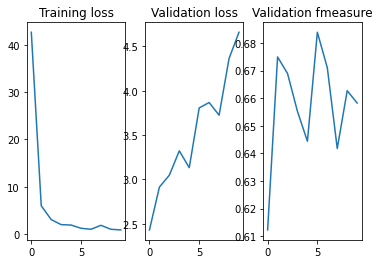

<Figure size 432x288 with 0 Axes>

In [ ]:
# Display the training and validation losses and (validation) f-measure over epochs
plt.figure()
plt.subplot(1, 3, 1)
plt.plot(loss_train_all_epochs)
plt.title('Training loss')
plt.subplot(1, 3, 2)
plt.plot(loss_val_all_epochs)
plt.title('Validation loss')
plt.subplot(1, 3, 3)
plt.plot(fmeasure_val_all_epochs)
plt.title('Validation fmeasure')
plt.show()
plt.savefig('output.png')

In [ ]:
# save the model to a checkpoint
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [ ]:
loss_last_epoch, f_measure = evaluate(net, test_loader)

In [ ]:
print(loss_last_epoch, f_measure)

4.5920286774635315 0.6645161290322581
